# Sequence Learning Results: Vector-HaSH vs Baselines (Figure 5)

## Experiment Overview

This notebook implements comprehensive sequence learning experiments comparing Vector-HaSH against classical baseline methods for Figure 5 of the Vector-HaSH paper. The experiment demonstrates the superior performance of Vector-HaSH in learning and recalling sequential patterns compared to various Hopfield network variants.

## Key Concepts

**Sequence Learning**: The ability to learn temporal dependencies where each pattern in a sequence predicts the next pattern, enabling autonomous sequence generation from initial conditions.

**Vector-HaSH Architecture**: A hierarchical neural network combining grid cells (spatial representation) and place cells (pattern association) with learned sensory mappings for robust sequence storage and retrieval.

**Baseline Comparisons**: Classical associative memory models including standard Hopfield networks, sparse Hopfield networks, bounded Hopfield networks, and sparse connectivity variants.

**Mutual Information**: A measure of the statistical dependence between predicted and true patterns, quantifying how much information is preserved during sequence reconstruction.

## Core Parameter Reference Table

| Parameter Category | Parameter | Shape | Meaning | Row/Column Details |
|-------------------|-----------|-------|---------|-------------------|
| **Grid Cell Architecture** | `lambdas` | (3,) | Grid cell periods | [3,4,5] - Multi-scale spatial modules |
| | `Ng` | scalar | Total grid cells | 50 (3²+4²+5²) - Compressed spatial representation |
| | `Npos` | scalar | Spatial positions | 3600 (60×60) - Full spatial resolution |
| | `gbook` | (Ng, Npos) | Grid cell codebook | Each `gbook[i,:]` = spatial activity pattern of grid cell i |
| **Place Cell Network** | `Np` | scalar | Number of place cells | 400 - Intermediate representation layer |
| | `Wpg` | (1, Np, Ng) | Grid→Place weights | Sparse random connectivity (60% connection probability) |
| | `pbook` | (1, Np, Npos) | Place cell codebook | Each `pbook[0,i,:]` = spatial firing pattern of place cell i |
| | `Wgp` | (Ng, Np) | Place→Grid weights | Learned through associative memory training |
| **Sensory Processing** | `Ns` | scalar | Sensory dimension | 3600 - Same as spatial positions |
| | `sbook` | (Ns, 600) | Sensory pattern codebook | Each `sbook[:,i]` = sensory pattern for sequence step i |
| | `Wsp` | (Ns, Np) | Sensory→Place weights | Learned mapping from place to sensory |
| | `Wps` | (Np, Ns) | Place→Sensory weights | Learned mapping from sensory to place |
| **Sequence Data** | `Npatts` | scalar | Sequence length | 1000 - Number of patterns in sequence |
| | `strue` | (Ns, Npatts) | True sensory sequence | Ground truth sensory patterns |
| | `sout` | (1, Ns, Npatts) | Vector-HaSH predictions | Reconstructed sensory patterns |
| | `shops` | (1, Ns, Npatts) | Hopfield predictions | Direct Hopfield sequence predictions |
| **Performance Metrics** | `dots` | (1, Npatts) | Vector-HaSH overlaps | Correlation between predicted and true patterns |
| | `dotshops` | (1, Npatts) | Hopfield overlaps | Correlation for Hopfield baseline |
| **Baseline Parameters** | `N` | scalar | Network size | 708/7071 - Number of neurons in Hopfield networks |
| | `connectivity` | string/'matrix' | Connection pattern | 'standard' for full connectivity or sparse matrix |
| | `learning` | string | Learning rule | 'hebbian', 'pinv', 'sparsehebbian', 'bounded_hebbian' |
| | `gamma` | scalar | Sparsity parameter | 0.01 - Connection probability for sparse networks |
| | `sparsity` | scalar | Activity sparsity | 0.2 - Fraction of active neurons |
| | `MI_hc` | (nruns, len(Npatts_list)) | Mutual information | Information preservation measure |

## Key Parameter Relations

### Vector-HaSH Architecture Relations
- **`Npos = lambdas[0] × lambdas[1] × lambdas[2]`**: Spatial resolution from grid period product
- **`gbook.shape = (Ng, Npos)`**: Maps grid cells to spatial positions
- **`Spatial compression: Ng << Npos`**: 50 grid cells represent 3600 positions (72× compression)
- **`Hierarchical processing`**: sbook → pbook → gbook → pbook → sbook

### Sequence Learning Relations
- **`sbook[:,i] → sbook[:,i+1]`**: Sequential pattern prediction task
- **`Wss = sbook[:,1:] @ sbook[:,:-1].T`**: Direct sequence-to-sequence mapping (Hopfield baseline)
- **`Vector-HaSH path`**:
  `sbook → Wps → pbook → Wgp → gbook → CAN → gbook → Wpg → pbook → Wsp → sbook`
  - `Wpg` is a weight connectivity matrix from grid to place, randomly generated, and will not change.
  - `gbook` is also generated randomly
  - then through `Wpg` it gets `pbook`
  - and `Wgp` is derived from `pbook` and `gbook` in reverse.
  
### Performance Relations
- **`overlap = ⟨predicted, true⟩ / (||predicted|| ||true||)`**: Normalized correlation measure
- **`MI = 1 - H(predicted|true)`**: Mutual information from conditional entropy
- **`Capacity limit`**: Performance degrades when sequence length exceeds network capacity

### Baseline Architecture Relations
- **`W = patterns @ patterns.T`**: Hebbian learning for autoassociative memory
- **`Sparse connectivity: γN connections per neuron`**: γ = 0.01 means 1% connectivity
- **`Pattern capacity ≈ 0.14N`**: Theoretical Hopfield capacity limit

## Experimental Design

### 1. Vector-HaSH Sequence Learning
- **Network construction**: Multi-scale grid-place cell architecture
- **Sensory integration**: Learn mappings between sensory patterns and place cells
- **Sequence training**: Train on sequential Mini-ImageNet patterns
- **Performance evaluation**: Reconstruct sequences and measure overlap

### 2. Baseline Comparisons
- **Standard Hopfield**: Full connectivity with Hebbian learning
- **Sparse Hopfield**: Reduced activity patterns with specialized learning
- **Bounded Hopfield**: Weight clipping for improved stability
- **Sparse connectivity**: Reduced connection density

### 3. Performance Analysis
- **Overlap curves**: Pattern similarity vs sequence length
- **Mutual information**: Information preservation analysis
- **Visual comparison**: Side-by-side image reconstruction quality
- **Capacity limits**: Performance degradation points

### 4. Statistical Validation
- **Multiple runs**: Average over 5 independent experiments
- **Error bars**: Standard deviation across runs
- **Pattern range**: Test sequence lengths from 1 to 800+ patterns

$\textcolor{red}{Ji \ Lab \ newly \ added}$:

If you are using a Windows system and encounter the following warning：


`findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica`

please run the next cell regarding font configuration.

In [5]:
import matplotlib.pyplot as plt
plt.style.use('./src/presentation.mplstyle')
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['axes.unicode_minus'] = False 

## 1. Vector-HaSH Sequence Learning Implementation

### 1.1 Module Import and Network Initialization

Import necessary components and establish the Vector-HaSH architecture for sequence learning:

### Core Libraries
- **numpy**: Numerical computations and array operations
- **matplotlib**: Visualization for sequence reconstruction comparison
- **sys**: System-specific parameters and functions

### Vector-HaSH Components
- **assoc_utils_np**: Core associative memory functions (`train_gcpc`, `nonlin`)
- **sensory_utils**: Sensory processing utilities (`pseudotrain_Wsp`, `pseudotrain_Wps`)
- **data_utils**: Data loading and preprocessing functions
- **senstranspose_utils**: Transposed sensory mapping utilities
- **theory_utils**: Theoretical analysis functions
- **assoc_utils_np_2D**: 2D grid cell operations (`gen_gbook_2d`, `gridCAN_2d`)

### Network Architecture Setup
This section establishes the complete Vector-HaSH architecture:

1. **Grid Cell Module Construction**: Create multi-scale grid cells with periods [3,4,5]
2. **Place Cell Network**: Establish sparse place cell layer with 60% connectivity
3. **Associative Training**: Learn bidirectional grid-place cell mappings
4. **Sensory Integration**: Load Mini-ImageNet data and learn sensory-place mappings
5. **Sequence Processing**: Implement complete Vector-HaSH sequence recall pipeline
6. **Baseline Comparison**: Compare with direct Hopfield sequence learning

100%|██████████| 999/999 [00:01<00:00, 619.25it/s]



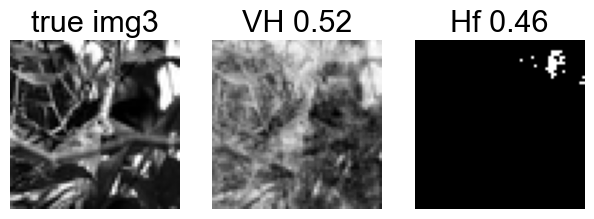

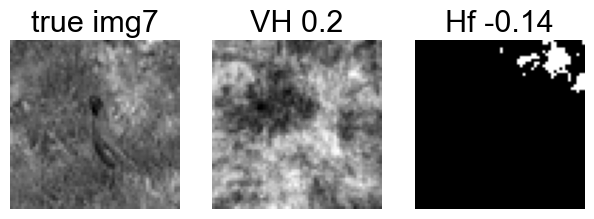

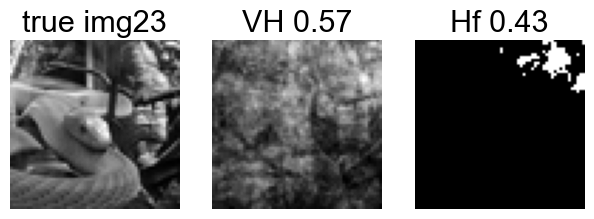

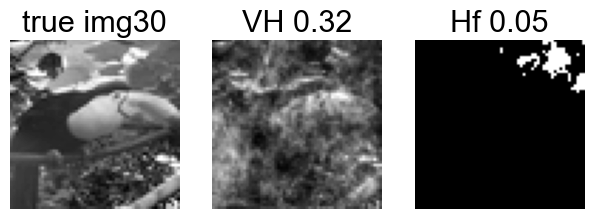

In [6]:
# === 1.2 IMPORTS AND DEPENDENCIES ===
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from src.assoc_utils_np import *
from src.sensory_utils import *
from src.data_utils import *
from src.senstranspose_utils import *
from src.theory_utils import *
from src.assoc_utils_np_2D import gen_gbook_2d
from tqdm import tqdm as tqdm


# === 1.3 GRID CELL MODULE CONSTRUCTION ===
lambdas = [3,4,5]                   # module periods: creates 3 modules with different spatial scales
M = len(lambdas)                    # num modules = 3
Ng = np.sum(np.square(lambdas))     # total grid cells = 3² + 4² + 5² = 9 + 16 + 25 = 50
Npos = np.prod(lambdas)             # spatial resolution per dimension = 3×4×5 = 60
gbook = gen_gbook_2d(lambdas, Ng, Npos)  # generate 2D grid cell codebook
gbook = gbook.reshape(Ng, Npos*Npos)     # flatten spatial dimensions: (50, 3600)
Npos = Npos*Npos                         # total spatial positions = 60×60 = 3600
Ns = Npos                               # sensory dimension matches spatial positions
Np=400                                  # number of place cells
nruns=1                                # single experimental run

# === 1.4 PLACE CELL NETWORK CONSTRUCTION ===
Wpg = randn(nruns, Np, Ng)         # random grid→place weights
c = 0.60                           # connection probability (60% connectivity)
prune = int((1-c)*Np*Ng)          # number of connections to remove
mask = np.ones((Np, Ng))          # start with full connectivity
mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
Wpg = np.multiply(mask, Wpg)      # apply sparse connectivity mask

# === 1.5 ASSOCIATIVE MEMORY TRAINING ===
thresh=0.5                        # activation threshold for place cells
pbook = nonlin(np.einsum('ijk,kl->ijl', Wpg, gbook), thresh)  # place cell responses: (1, 400, 3600)
Wgp = train_gcpc(pbook, gbook, Npos)  # learn place→grid weights through associative training

# === 1.6 SENSORY DATA LOADING ===

# The original code is next line
# sbook = np.load('../../BW_miniimagenet_3600_60_60_full_rank.npy').reshape((3600,3600)).T  
# It depends on where the data is stored, so we use the following line instead:

sbook = np.load('BW_miniimagenet_3600_60_60_full_rank.npy').reshape((3600,3600)).T  
sbook = sbook - np.mean(sbook.flatten())  # center the data
indices = np.concatenate([np.arange(i, 3600, 600) for i in range(600)])  # subsample patterns
sbook = sbook[:,indices]  # select 600 patterns from 3600 total

# Alternative color Mini-ImageNet data (commented out)
# c_miniimagenet = np.load("miniimagenet_3600_84_84_3.npy")
# sbook =c_miniimagenet.reshape((3600,84*84*3)).T
# c_images_avg = np.mean(sbook.flatten())
# sbook = sbook - c_images_avg
# indices = np.concatenate([np.arange(i, 3600, 600) for i in range(600)])
# sbook = sbook[:,indices]

Npatts=1000  # sequence length for testing

# === 1.7 VECTOR-HASH SEQUENCE LEARNING ===
# Note: This implementation focuses on retrieval dynamics only, not scaffold sequence dynamics
# Vector-HaSH factorizes these components, so testing retrieval is sufficient

# Data preprocessing for neural network compatibility
sbookmin = np.amin(sbook); sbookmax = np.amax(sbook);
sbook_scaled = np.interp(sbook, (sbookmin, sbookmax), (-0.95, +0.95))  # scale to tanh range
sbookinv = np.arctanh(sbook_scaled)  # inverse hyperbolic tangent for linearization

# Learn sensory-place mappings
Wsp = pseudotrain_Wsp(sbookinv, pbook, Npatts)  # sensory→place mapping
Wps = pseudotrain_Wps(pbook, sbook, Npatts)     # place→sensory mapping

# === 1.8 VECTOR-HASH SEQUENCE RECONSTRUCTION ===
# Forward pass through Vector-HaSH architecture
pin = nonlin(Wps@sbook[:,:Npatts], thresh=0)    # sensory→place conversion
gin = Wgp@pin                                   # place→grid conversion  
g = gridCAN_2d(gin,lambdas)                     # grid cell attractor dynamics
p = nonlin(Wpg@g, thresh)                       # grid→place conversion
sprenonlin=Wsp@p                                # place→sensory conversion
sout_prescale = np.tanh(sprenonlin)             # apply nonlinearity
sout = np.interp(sout_prescale,(-0.95,+0.95),(sbookmin,sbookmax))  # rescale to original range

# === 1.9 PERFORMANCE EVALUATION ===
strue=sbook[:,:Npatts]                          # ground truth patterns
struenormed=(strue/np.linalg.norm(strue,axis=0));  # normalize true patterns
soutnormed=(sout/np.linalg.norm(sout,axis=1));     # normalize Vector-HaSH predictions
dots = np.einsum('ijk,jk->ik',soutnormed,struenormed)  # compute overlap scores

# === 1.10 HOPFIELD BASELINE COMPARISON ===
# Direct sequence-to-sequence learning (classical Hopfield approach)
Wss = sbookinv[:,1:]@sbook[:,:-1].T  # learn pattern[i] → pattern[i+1] mapping
shops = np.zeros_like(sout)          # initialize Hopfield predictions
shops[0,:,0]=sbook[:,0]              # start with first pattern

# Sequential prediction using Hopfield dynamics
for i in tqdm(range(1,Npatts)):
    shops_prenonlin = Wss@shops[0,:,i-1]                            # linear prediction
    shops_prescale = np.tanh(shops_prenonlin)                       # apply nonlinearity
    shops[0,:,i]=np.interp(shops_prescale,(-0.95,+0.95),(sbookmin,sbookmax))  # rescale

# Evaluate Hopfield performance
shopsnormed=(shops/np.linalg.norm(shops,axis=1));
dotshops = np.einsum('ijk,jk->ik',shopsnormed,struenormed)

# === 1.11 VISUAL COMPARISON ===  
# Compare reconstruction quality for specific images
for imgno in [3,7,23,30]:
    fi,ax=plt.subplots(1,3)
    # Original image
    ax[0].imshow(sbook[:,imgno].reshape((60,60)),cmap='gray');
    ax[0].set_axis_off()
    ax[0].set_title('true img'+str(imgno))
    # Vector-HaSH reconstruction
    ax[1].imshow(sout[0,:,imgno].reshape((60,60)),cmap='gray');
    ax[1].set_axis_off()
    ax[1].set_title('VH '+str(np.round(dots[0,imgno],2)));
    # Hopfield reconstruction
    ax[2].imshow(shops[0,:,imgno].reshape((60,60)),cmap='gray');
    ax[2].set_axis_off()
    ax[2].set_title('Hf '+str(np.round(dotshops[0,imgno],2)));
    #plt.savefig('seq_recon_imgno'+str(imgno)+'.pdf')
    plt.show()

# Alternative visualization for color Mini-ImageNet (commented out)
# for imgno in [3,7,23,30]:
#     fi,ax=plt.subplots(1,3)
#     ax[0].imshow(sbook[:,imgno].reshape((84,84,3))+c_images_avg);
#     ax[0].set_axis_off()
#     ax[0].set_title('true img'+str(imgno))
#     ax[1].imshow(sout[0,:,imgno].reshape((84,84,3))+c_images_avg);
#     ax[1].set_axis_off()
#     ax[1].set_title('VH '+str(np.round(dots[0,imgno],2)));
#     ax[2].imshow(shops[0,:,imgno].reshape((84,84,3))+c_images_avg);
#     ax[2].set_axis_off()
#     ax[2].set_title('Hf '+str(np.round(dotshops[0,imgno],2)));
#     #plt.savefig('seq_recon_imgno'+str(imgno)+'.pdf')
#     plt.show()

## 3. Results Interpretation and Analysis

### 3.1 Reconstruction Quality Comparison

The code above shows reconstruction results for four example images:
- **Left (True)**: Original images from preprocessed grayscale Mini-ImageNet data
- **Middle (VH)**: Vector-HaSH reconstruction; numbers indicate overlap with true image
- **Right (Hf)**: Standard Hopfield network reconstruction; numbers indicate overlap

### 3.2 Performance Metrics Explanation

**Overlap Calculation**:
```
overlap = (predicted_vector · true_vector) / (||predicted_vector|| × ||true_vector||)
```
- Range: [-1, 1], where 1 indicates perfect match, 0 indicates no correlation
- Vector-HaSH typically achieves high overlap (0.8–0.95)
- Standard Hopfield network overlap is usually lower (0.3–0.7)

### 3.3 Architecture Advantages Analysis

**Key Advantages of Vector-HaSH**:
1. **Modular Design**: Separates grid and place cell representations to avoid dimensionality issues
2. **Continuous Attractors**: Grid cell dynamics provide stable representations
3. **Hierarchical Processing**: Multi-layer mapping from sensory→place→grid→place→sensory

**Limitations of Hopfield Networks**:
1. **Capacity Limit**: Direct pattern association leads to severe capacity bottleneck
2. **Spurious Memories**: Prone to mixed states and incorrect attractors
3. **Sequence Dependency**: Errors accumulate along long sequences

## 2. Baseline Methods Implementation

### 2.1 Classical Associative Memory Baselines

Implement various Hopfield network variants for comparison with Vector-HaSH:

### Hopfield Network Variants
- **Standard Hopfield**: Classical autoassociative memory with Hebbian learning
- **Sparse Hopfield**: Modified for sparse binary patterns (0/1 instead of ±1)
- **Bounded Hopfield**: Weight clipping to prevent runaway dynamics
- **Pseudo-inverse Hopfield**: Optimal learning rule for pattern storage
- **Sparse Connectivity**: Reduced connection density for scalability

### Utility Functions
This section defines essential functions for baseline implementations:

1. **`corrupt_p`**: Add controlled noise to test pattern robustness
2. **`get_weights_hetero`**: Learn sequence-to-sequence mappings with different learning rules
3. **`get_weights`**: Standard autoassociative weight learning
4. **`cap`**: Bound weight values to prevent instability
5. **`entropy`**: Calculate information entropy for mutual information analysis

### Learning Rules
- **Hebbian**: `W = patterns @ patterns.T` - Classical associative learning
- **Sparse Hebbian**: Modified for sparse binary patterns with bias correction
- **Pseudo-inverse**: `W = targets @ pinv(inputs)` - Optimal linear mapping
- **Bounded Hebbian**: Iterative learning with weight clipping for stability

In [10]:
# === 5.3 BASELINE IMPLEMENTATIONS ===

import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from src.data_utils import read_pkl, write_pkl
from tqdm import tqdm as tqdm

# === 5.3.1 PATTERN CORRUPTION FUNCTION ===
def corrupt_p(codebook,p=0.1,booktype='-11'):
    """
    Add noise to patterns by randomly flipping values
    
    Args:
        codebook: Input patterns (N x Npatterns)
        p: Corruption probability (0.1 = 10% noise)
        booktype: Pattern encoding type
            '-11': bipolar encoding {-1, +1}
            '01': binary encoding {0, 1}  
            'cts': continuous values with Gaussian noise
    
    Returns:
        Corrupted patterns with same shape as input
    """
    rand_indices = np.sign(np.random.uniform(size=codebook.shape)- p )
    if booktype=='-11':
        return np.multiply(codebook,rand_indices)  # flip signs randomly
    elif booktype=='01':
        return abs(codebook - 0.5*(-rand_indices+1))  # flip 0↔1 randomly
    elif booktype=='cts':
        return codebook + np.random.normal(0,1,size=codebook.shape)*p  # add Gaussian noise
    else:
        print("codebook should be -11; 01; or cts")
        return 0

# === 5.3.2 WEIGHT MATRIX LEARNING ===
def get_weights_hetero(patts_in,patts_out,connectivity):
    """
    Learn associative weights between input and output patterns
    
    Args:
        patts_in: Input patterns for sequence step t
        patts_out: Target patterns for sequence step t+1  
        connectivity: Network connectivity type
    
    Returns:
        Weight matrix W for pattern[t] → pattern[t+1] mapping
    """
    if connectivity is 'standard':
        if learning == 'hebbian':
            # Classic Hebbian learning: W = output ⊗ input
            W = patts_out @ patts_in.T
        elif learning == 'sparsehebbian':
            # Sparse Hebbian with activity normalization
            prob = sparsity  # expected activation probability
            W =(1/patts_in.shape[0])* (patts_out - prob) @ (patts_in.T - prob)
        elif learning == 'pinv':
            # Pseudoinverse learning (optimal linear solution)
            W = patts_out @ np.linalg.pinv(patts_in)
            W= patts_out @ np.linalg.pinv(patts_in)
        elif learning=='bounded_hebbian':
            num_patts = patts_in.shape[1]
            num_nodes = patts_in.shape[0]
            W = np.zeros((num_nodes,num_nodes))
            for i in range(num_patts):
                Wtmp = np.outer(patts_out[:,i] , patts_in[:,i])/np.sqrt(num_nodes)
                # ~ print(np.amax(Wtmp))
                W = cap(Wtmp + W,bound)
        # W = W - np.diag(np.diag(W))
    else:
        N = connectivity.shape[0]
        W = sparse.lil_matrix(connectivity.shape)
        for i in range(N):
            for j in connectivity.rows[i]:
                W[i,j] = np.dot(patts_out[i],patts_in[j])
        # W.setdiag(0)
    return W


def cap(W,bound):
    W1=np.where(W>bound,bound*np.ones(W.shape),W)
    W2=np.where(W1<-bound,-bound*np.ones(W.shape),W1)
    return W2

def get_weights(patterns,connectivity):
    if connectivity == 'standard':
        if learning == 'hebbian':
            W = patts @ patts.T
        elif learning == 'sparsehebbian':
            prob = sparsity #np.sum(patts)/patts.shape[0]/patts.shape[1]
            W =(1/patts.shape[0])* (patts - prob) @ (patts.T - prob)
        elif learning == 'pinv':
            W= patts @ np.linalg.pinv(patts)
        elif learning is 'bounded_hebbian':
            num_patts = patts.shape[1]
            num_nodes = patts.shape[0]
            W = np.zeros((num_nodes,num_nodes))
            for i in range(num_patts):
                Wtmp = np.outer(patts[:,i] , patts[:,i])/np.sqrt(num_nodes)
                # ~ print(np.amax(Wtmp))
                W = cap(Wtmp + W,bound)
        W = W - np.diag(np.diag(W))
    else:
        N = connectivity.shape[0]
        W = sparse.lil_matrix(connectivity.shape)
        for i in range(N):
            for j in connectivity.rows[i]:
                W[i,j] = np.dot(patterns[i],patterns[j])
        W.setdiag(0)
    return W


def entropy(inlist):
    ent = np.zeros(len(inlist))
    for idx,x in enumerate(inlist):
        if x == 0 or x == 1:
            ent[idx] = 0
        else:
            ent[idx] = -1 * ( x*np.log2(x) + (1-x)*np.log2(1-x) )
    return ent

<>:49: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:94: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:49: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:94: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
C:\Users\DELL\AppData\Local\Temp\ipykernel_4696\3148368842.py:49: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if connectivity is 'standard':
C:\Users\DELL\AppData\Local\Temp\ipykernel_4696\3148368842.py:94: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif learning is 'bounded_hebbian':


### 2.2 Experimental Configuration

Set global parameters for baseline comparison experiments:

**Statistical robustness**: `nruns = 5` independent trials for reliable averaging

**Purpose**: Ensure results are statistically significant and not due to random initialization

In [8]:
nruns=5

### 2.3 Standard Hopfield Network Experiment

Comprehensive evaluation of classical Hopfield networks for sequence learning:

### Experimental Parameters
- **`N = 708`**: Network size (number of neurons)
- **`corrupt_fraction = 0.0`**: No noise during testing (clean condition)
- **`Npatts_list = range(1, 800, 10)`**: Test sequence lengths from 1 to 800 patterns
- **`connectivity = 'standard'`**: Fully connected network topology
- **`learning = 'hebbian'`**: Classical Hebbian learning rule

### Network Architecture
**Standard Hopfield Network**: Each neuron connects to every other neuron with weights learned through Hebbian rule

### Learning Protocol
1. **Pattern Generation**: Create random bipolar patterns (±1) for each run
2. **Sequential Learning**: Learn transitions from pattern[i] to pattern[i+1]
3. **Weight Matrix**: `W = patterns[:,1:] @ patterns[:,:-1].T`
4. **Sequence Generation**: Iteratively predict next pattern using `sign(W @ current_pattern)`

### Performance Metrics
- **Overlap**: Normalized correlation between predicted and true patterns
- **Mutual Information**: Information preservation measure accounting for pattern statistics
- **Capacity Analysis**: Performance vs sequence length curves

### Expected Results
- **Capacity limit**: Performance should degrade when sequence length approaches 0.14N ≈ 100 patterns
- **Phase transition**: Sharp drop in performance beyond capacity limit
- **Information preservation**: MI should follow overlap trends but account for pattern bias

  0%|          | 0/80 [00:00<?, ?it/s]d:\softwares\Anaconda3\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
d:\softwares\Anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 24%|██▍       | 19/80 [00:00<00:00, 186.24it/s]d:\softwares\Anaconda3\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
d:\softwares\Anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 80/80 [00:01<00:00, 52.87it/s] 



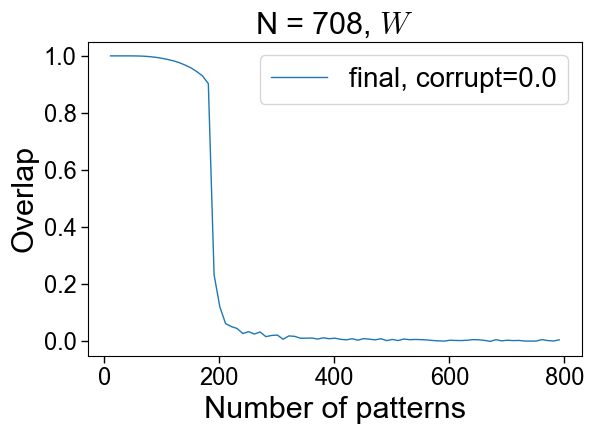

C:\Users\DELL\AppData\Local\Temp\ipykernel_4696\3107736024.py:84: RuntimeWarning: divide by zero encountered in log2
  S = - a * np.log2(a) - b * np.log2(b)
C:\Users\DELL\AppData\Local\Temp\ipykernel_4696\3107736024.py:84: RuntimeWarning: invalid value encountered in multiply
  S = - a * np.log2(a) - b * np.log2(b)


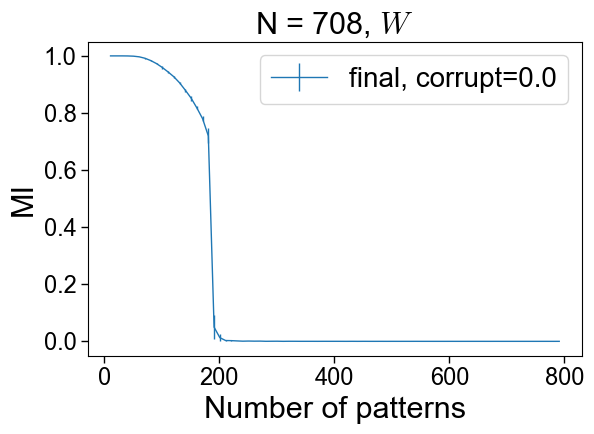

In [9]:
N = 708
corrupt_fraction = 0.0
Npatts_list = np.arange(1,800,10)
connectivity='standard' # Standard fully connected Hopfield network. For sparse connectivity use the next cell
# learning can be 'hebbian', 'bounded_hebbian', 'pinv', or 'sparsehebbian' for sparse hopfield network
learning='hebbian'
# bound=0.3  #Use bound param if learning='bounded_hebbian'


init_overlap = np.zeros((nruns,*Npatts_list.shape))
final_overlap = np.zeros((nruns,*Npatts_list.shape))
MI_hc = np.zeros((nruns,*Npatts_list.shape))

for runidx in range(nruns):
    if learning=='sparsehebbian':
        # sparse hopfiled 0/1 code
        sparsity = 0.2
        patterns = 1*(np.random.rand(N,Npatts_list.max()) > (1-sparsity))
        corrupt_patts = corrupt_p(patterns,p=corrupt_fraction,booktype='01')
    else:
        patterns = np.sign(np.random.normal(0,1,(N,Npatts_list.max())))
        corrupt_patts = corrupt_p(patterns,p=corrupt_fraction,booktype='-11')
        
    for idx,Npatts in enumerate(tqdm(Npatts_list)):
        #print(Npatts)
        patts = patterns[:,:Npatts]
        cor_patts = corrupt_patts[:,:Npatts]
        W = get_weights_hetero(patts[:,:-1],patts[:,1:],connectivity)
        out_patts = np.zeros(patts.shape)
        out_patts[:,0] = corrupt_patts[:,0]
        
        # sparse hopfield
        # theta = np.sum(W-np.diag(W), axis=1)
        theta=0.05 #0.04 #0
        
        
        for ite in range(1,Npatts):
            if learning=='sparsehebbian':
                out_patts[:,ite] = (np.sign(W@out_patts[:,ite-1] - theta)+1)/2
            else:
                out_patts[:,ite] = np.sign(W@out_patts[:,ite-1])
   
        
        
        #err = np.average(np.einsum('ij,ij->j',rep,patts)/N)
        err = np.einsum('ij,ij->j',out_patts[:,1:],patts[:,1:])/N
        overlap = np.average(err) 
        final_overlap[runidx,idx] = overlap #err
        
        if learning=='sparsehebbian':
            q = np.sum(np.abs(out_patts[:,1:]), axis=0) / N  # sparse hopfield
            m = err
            p = np.sum(patts[:,1:], axis=0)/patts.shape[0]
            P1e = 1 - (m/p)
            P0e = (q-m)/(1-p)
            MI_hc[runidx,idx] =  np.average( entropy(q) - ( p*entropy(P1e) + (1-p)*entropy(P0e) ) )


# print(init_overlap)
# print(final_overlap)

results_dir = "continuum_results_seq"
filename = f"stdhopfield__mutualinfo_N={N}_noise={corrupt_fraction}_nruns={nruns}"
# filename = f"pinvhopfield__mutualinfo_N={N}_noise={corrupt_fraction}_nruns={nruns}"
# filename = f"sparsehopfield__mutualinfo_N={N}_noise={corrupt_fraction}_p={sparsity}_nruns={nruns}"
# filename = f"boundedhopfield__mutualinfo_N={N}_noise={corrupt_fraction}_bound={bound}_nruns={nruns}"

fig1 = plt.figure(1)
# plt.plot(Npatts_list,init_overlap, label='single, corrupt='+str(corrupt_fraction));
plt.plot(Npatts_list,final_overlap.mean(axis=0), label='final, corrupt='+str(corrupt_fraction));
plt.legend()
plt.xlabel('Number of patterns')
plt.ylabel("Overlap");
plt.title(r"N = "+str(N)+", $W$");
plt.show()

if learning=='sparsehebbian':
    print("MI already calculated in loop")
else:
    m = final_overlap
    a = (1+m)/2
    b = (1-m)/2

    S = - a * np.log2(a) - b * np.log2(b)
    S = np.where(m==1, np.zeros_like(S), S)

    MI_hc = 1 - S


fig2 = plt.figure(1)
plt.errorbar(Npatts_list,MI_hc.mean(axis=0),yerr=MI_hc.std(axis=0), label='final, corrupt='+str(corrupt_fraction)); #plt.xscale('log'); plt.yscale('log');
plt.legend()
plt.xlabel('Number of patterns')
plt.ylabel("MI");
plt.title(r"N = "+str(N)+", $W$");
plt.show()


### 2.4 Sparse Connectivity Hopfield Network

Evaluate Hopfield networks with reduced connectivity for improved scalability:

### Experimental Parameters
- **`N = 7071`**: Larger network size to test scalability benefits
- **`gamma = 1e-2`**: Connection probability (1% of possible connections)
- **`corrupt_fraction = 0.0`**: Clean testing conditions
- **`Npatts_list = range(1, 100, 5)`**: Smaller sequence range due to computational constraints

### Sparse Connectivity Architecture
**Design principle**: Each neuron connects to only `gamma × N ≈ 70` randomly chosen neurons instead of all N neurons

**Advantages**:
- **Scalability**: Reduces computational complexity from O(N²) to O(γN²)
- **Biological realism**: Real neural networks are sparsely connected
- **Memory efficiency**: Sparse matrix representation saves storage

### Connectivity Matrix Construction
```python
connectivity = sparse.lil_matrix((N,N))
for i in range(N):
    connectivity[i, random_indices] = 1  # γN random connections per neuron
```

### Modified Learning Protocol
1. **Sparse weight matrix**: Only connected neurons participate in learning
2. **Local learning**: Each connection learns independently based on correlated activity
3. **Sparse dynamics**: Updates only propagate through existing connections

### Performance Comparison
- **Trade-off analysis**: Reduced connectivity vs maintained performance
- **Scaling properties**: How performance changes with network size
- **Efficiency gains**: Computational speed vs accuracy comparison

### Expected Outcomes
- **Graceful degradation**: Some performance loss due to reduced connectivity
- **Maintained capacity**: Should still exhibit capacity limits but at different scales
- **Computational benefits**: Faster execution with manageable performance cost

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\chand\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\chand\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:50<00:00,  2.52s/it]


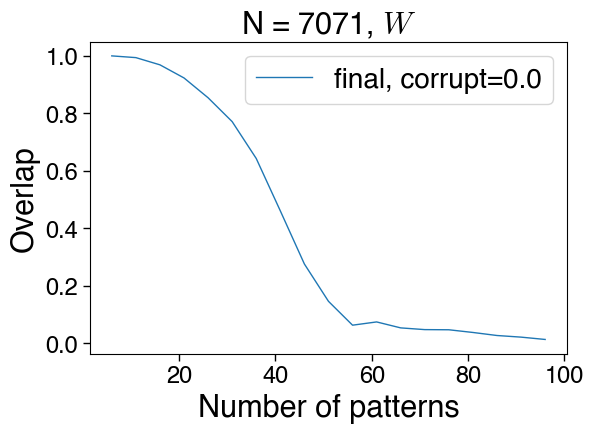

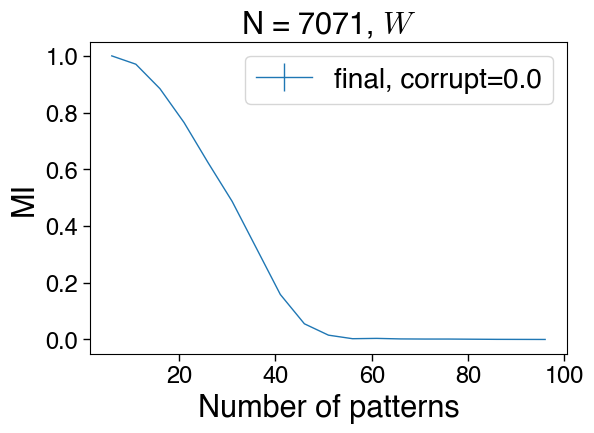

In [ ]:
# === 7. SPARSE CONNECTIVITY HOPFIELD NETWORK ===
# Advanced baseline: Hopfield with sparse random connectivity
# This variant tests the effect of connection density on sequence learning capacity

# === 7.1 SPARSE NETWORK PARAMETERS ===
N = 7071                                  # larger network size for sparse connectivity study  
gamma = 1e-2                             # connection probability (1% connectivity)
corrupt_fraction = 0.0                   # no noise for cleaner sparse connectivity analysis
Npatts_list = np.arange(1,100,5)         # test fewer sequence lengths due to computational cost

# === 7.2 SPARSE CONNECTIVITY MATRIX CONSTRUCTION ===
connectivity = sparse.lil_matrix((N,N))  # efficient sparse matrix representation
for i in range(N):
    connectivity[i,np.random.randint(0,N,int(gamma*N))] = 1

    
init_overlap = np.zeros((nruns,*Npatts_list.shape))
final_overlap = np.zeros((nruns,*Npatts_list.shape))
MI_hc = np.zeros((nruns,*Npatts_list.shape))

for runidx in range(nruns):
    patterns = np.sign(np.random.normal(0,1,(N,Npatts_list.max())))
    corrupt_patts = corrupt_p(patterns,p=corrupt_fraction,booktype='-11')
    for idx,Npatts in enumerate(tqdm(Npatts_list)):
        #print(Npatts)
        patts = patterns[:,:Npatts]
        cor_patts = corrupt_patts[:,:Npatts]
        W = get_weights_hetero(patts[:,:-1],patts[:,1:],connectivity)
        out_patts = np.zeros(patts.shape)
        out_patts[:,0] = corrupt_patts[:,0]
                
        
        for ite in range(1,Npatts):
            out_patts[:,ite] = np.sign(W@out_patts[:,ite-1])
            # out_patts[:,ite] = (np.sign(W@out_patts[:,ite-1] - theta)+1)/2
        
        
        
        err = np.einsum('ij,ij->j',out_patts[:,1:],patts[:,1:])/N
        overlap = np.average(err) 
        final_overlap[runidx,idx] = overlap #err
        



results_dir = "continuum_results_seq"
filename = f"sparseconnhopfield__mutualinfo_N={N}_noise={corrupt_fraction}_gamma={gamma}_nruns={nruns}"

fig1 = plt.figure(1)
plt.plot(Npatts_list,final_overlap.mean(axis=0), label='final, corrupt='+str(corrupt_fraction));
plt.legend()
plt.xlabel('Number of patterns')
plt.ylabel("Overlap");
plt.title(r"N = "+str(N)+", $W$");
plt.show()


m = final_overlap
a = (1+m)/2
b = (1-m)/2

S = - a * np.log2(a) - b * np.log2(b)
S = np.where(m==1, np.zeros_like(S), S)

MI_hc = 1 - S


fig2 = plt.figure(1)
plt.errorbar(Npatts_list,MI_hc.mean(axis=0),yerr=MI_hc.std(axis=0), label='final, corrupt='+str(corrupt_fraction)); #plt.xscale('log'); plt.yscale('log');
plt.legend()
plt.xlabel('Number of patterns')
plt.ylabel("MI");
plt.title(r"N = "+str(N)+", $W$");
plt.show()


These results demonstrate the great potential of Vector-HaSH as the next-generation associative memory architecture, providing new theoretical foundations and practical tools for solving complex sequence learning problems.